First Process the Images
* Load the Images
* Crop According to the annotations
* save cropped images to a new folder
* for images in cropped folder, split into 20% test, 80% train
* augment the images if there's not enough data
* run the models

In [1]:
#breed_list = os.listdir("dogs/images/Images/")
image_path = 'dogs/images/Images/'
annot_path = 'dogs/annotations/Annotation/'
work_path = 'dogs/working/cropped/'
#Special case for mac because for mac there is .DS_store

In [2]:
import os

breeds = [f for f in os.listdir(image_path) if not f.startswith('.')]

num_classes = len(breeds)
print("{} breeds".format(num_classes))

n_total_images = 0
breed_count_dict = {}
for breed in breeds:
    n_total_images += len(os.listdir(f"{image_path}{breed}"))
    breed_count_dict[breed]=len(os.listdir(f"{image_path}{breed}"))
print("{} images".format(n_total_images))

120 breeds
20580 images


About how many images are there for each breed? Which breed has the most images?

In [3]:
breed_count_dict

{'n02097658-silky_terrier': 183,
 'n02092002-Scottish_deerhound': 232,
 'n02099849-Chesapeake_Bay_retriever': 167,
 'n02091244-Ibizan_hound': 188,
 'n02095314-wire-haired_fox_terrier': 157,
 'n02091831-Saluki': 200,
 'n02102318-cocker_spaniel': 159,
 'n02104365-schipperke': 154,
 'n02090622-borzoi': 151,
 'n02113023-Pembroke': 181,
 'n02105505-komondor': 154,
 'n02093256-Staffordshire_bullterrier': 155,
 'n02113799-standard_poodle': 159,
 'n02109961-Eskimo_dog': 150,
 'n02089973-English_foxhound': 157,
 'n02099601-golden_retriever': 150,
 'n02095889-Sealyham_terrier': 202,
 'n02085782-Japanese_spaniel': 185,
 'n02097047-miniature_schnauzer': 154,
 'n02110063-malamute': 178,
 'n02105162-malinois': 150,
 'n02086079-Pekinese': 149,
 'n02097130-giant_schnauzer': 157,
 'n02113978-Mexican_hairless': 155,
 'n02107142-Doberman': 150,
 'n02097209-standard_schnauzer': 155,
 'n02115913-dhole': 150,
 'n02106662-German_shepherd': 152,
 'n02106382-Bouvier_des_Flandres': 150,
 'n02110185-Siberian_hus

In [4]:
import pandas as pd
breed_count_df = pd.DataFrame({'breed':breed_count_dict.keys(),'breed_counts':breed_count_dict.values()})
breed_count_df.head()

,breed,breed_counts
0,n02097658-silky_terrier,183
1,n02092002-Scottish_deerhound,232
2,n02099849-Chesapeake_Bay_retriever,167
3,n02091244-Ibizan_hound,188
4,n02095314-wire-haired_fox_terrier,157


In [5]:
breed_count_df.sort_values(by='breed_counts',ascending=False,inplace=True)

In [6]:
breed_count_df.head(10)

,breed,breed_counts
38,n02085936-Maltese_dog,252
105,n02088094-Afghan_hound,239
1,n02092002-Scottish_deerhound,232
114,n02112018-Pomeranian,219
56,n02107683-Bernese_mountain_dog,218
91,n02111889-Samoyed,218
49,n02090721-Irish_wolfhound,218
71,n02086240-Shih-Tzu,214
103,n02111500-Great_Pyrenees,213
118,n02111129-Leonberg,210


In [7]:
breed_count_df.tail(10)

,breed,breed_counts
28,n02106382-Bouvier_des_Flandres,150
40,n02104029-kuvasz,150
15,n02099601-golden_retriever,150
72,n02110627-affenpinscher,150
101,n02101556-clumber,150
107,n02102177-Welsh_springer_spaniel,150
20,n02105162-malinois,150
47,n02106166-Border_collie,150
21,n02086079-Pekinese,149
48,n02090379-redbone,148


For the 120 breeds, the top ten breeds had about 200 images per breed.  For the bottom 10 breeds, we had about 150 images.  Now let's crop the images. Now might not also be a bad time to augment images too for training. Let's create two folders, one for the cropped images and then one for the cropped and augmented images

In [8]:
import xml.etree.ElementTree as ET
from PIL import Image

#this function adapted from https://www.kaggle.com/hengzheng/dog-breeds-classifier
def save_cropped_img(path, annotation, newpath):
    tree = ET.parse(annotation)
    xmin = int(tree.getroot().findall('.//xmin')[0].text)
    xmax = int(tree.getroot().findall('.//xmax')[0].text)
    ymin = int(tree.getroot().findall('.//ymin')[0].text)
    ymax = int(tree.getroot().findall('.//ymax')[0].text)
    image = Image.open(path)
    image = image.crop((xmin, ymin, xmax, ymax))
    image = image.convert('RGB')
    image.save(newpath)

def crop_images(data_dir,annotations_dir,cropped_dir):
    # breeds = os.listdir(data_dir)
    # annotations = os.listdir(annotations_dir)
    
    breeds = [f for f in os.listdir(data_dir) if not f.startswith('.')]
    annotations = [f for f in os.listdir(annotations_dir) if not f.startswith('.')]
    
    print('breeds: ', len(breeds), 'annotations: ', len(annotations))

    total_images = 0

    for breed in breeds:
        dir_list = os.listdir(data_dir + breed)
        annotations_dir_list = os.listdir(annotations_dir + breed)
        img_list = [data_dir + breed + '/' + i for i in dir_list]
        os.makedirs(cropped_dir + breed)

        for file in img_list:
            annotation_path = annotations_dir + breed + '/' + os.path.basename(file[:-4])
            newpath = cropped_dir + breed + '/' + os.path.basename(file)
            save_cropped_img(file, annotation_path, newpath)
            total_images += 1
    
    print("total images cropped", total_images)

crop_images(image_path,annot_path,work_path)

breeds:  120 annotations:  120


FileExistsError: [Errno 17] File exists: 'dogs/working/cropped/n02097658-silky_terrier'

Load images, resize and normalize

In [10]:
#!pip install opencv-python
import cv2
import numpy as np

def load_images_and_labels(categories,fpath):
    img_lst=[]
    labels=[]
    label_names=[]
    paths=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            paths.append(category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            img_array = Image.fromarray(img, 'RGB')
            
            #resize image to 227 x 227 because the input image resolution for AlexNet is 227 x 227
            resized_img = img_array.resize((227, 227))
            
            img_lst.append(np.array(resized_img))
            label_names.append(category)
            labels.append(index)
    return img_lst, labels, label_names, paths


img_lst, labels, label_names, paths = load_images_and_labels(breeds,work_path)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels),"\nNo. of label names = ",len(label_names))
print(type(images),type(labels),type(label_names),type(paths))

No. of images loaded =  20580 
No. of labels loaded =  20580 
No. of label names =  20580
<class 'list'> <class 'list'> <class 'list'>


In [ ]:
len(paths)

20580

In [11]:
images = np.array(images)
labels = np.array(labels)
paths = np.array(paths)
label_names = np.array(label_names)
print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape,"\nPaths shape = ",paths.shape,"\nLabel Names shape = ",label_names.shape)
print(type(images),type(labels),type(paths))

Images shape =  (20580, 227, 227, 3) 
Labels shape =  (20580,) 
Paths shape =  (20580,) 
Label Names shape =  (20580,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


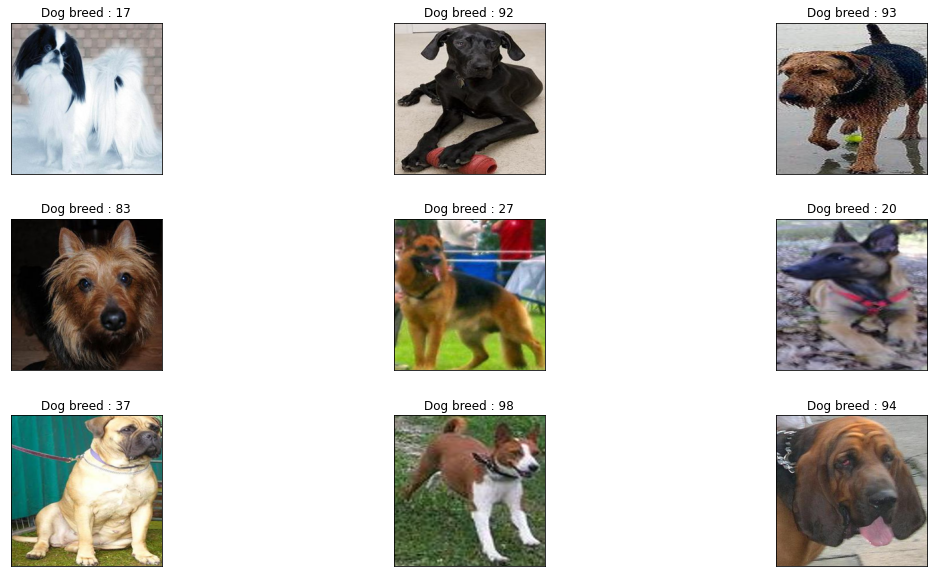

In [ ]:
import matplotlib.pyplot as plt
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Dog breed : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_rand_images(images, labels)

In [ ]:
from sklearn.model_selection import train_test_split

In [12]:
random_seed = 123
#1-step in data shuffling

#get equally spaced numbers in a given range
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

#shuffle all the equally spaced values in list 'n'
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [    0     1     2 ... 20577 20578 20579]

'n' values after shuffling =  [15168  6796 19532 ... 17730 15725 19966]


In [13]:
#2-step in data shuffling

#shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]
paths = paths[n]
label_names = label_names[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape,"\n Paths shape after shuffling= ",paths.shape)

Images shape after shuffling =  (20580, 227, 227, 3) 
Labels shape after shuffling =  (20580,) 
 Paths shape after shuffling=  (20580,)


In [14]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (20580, 227, 227, 3)


# Map the label names to label numbers

In [16]:
label_df = pd.DataFrame({'labels':labels,'label_names':label_names})
label_df.head()

,labels,label_names
0,88,n02089867-Walker_hound
1,40,n02104029-kuvasz
2,114,n02112018-Pomeranian
3,1,n02092002-Scottish_deerhound
4,20,n02105162-malinois


Check for duplicates, each label number should map to a label name

In [17]:
label_df.drop_duplicates(inplace=True)

In [18]:
label_df.shape

(120, 2)

In [38]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (16464, 227, 227, 3)
y_train shape =  (16464,)

x_test shape =  (4116, 227, 227, 3)
y_test shape =  (4116,)


In [39]:
#Export the paths too
path_train, path_test, path_y_train, path_y_test = train_test_split(paths, labels, test_size = 0.2, random_state = random_seed)


n02094258-Norwich_terrier/n02094258_2672.jpg
30
30


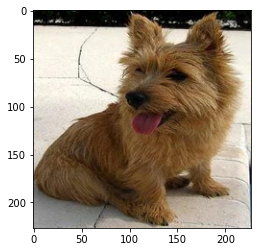

In [40]:
index=456
print(path_train[index])
print(path_y_train[index])
print(y_train[index])
plt.imshow(x_train[index])

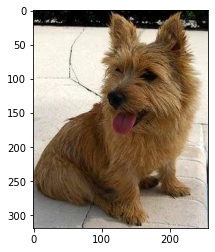

In [41]:
img_chk = Image.open(work_path+"/"+path_train[index])
plt.imshow(img_chk)

Let's save the resized and normalized images into train/breed/image and test/breed/image folders

In [43]:
train_dir = 'dogs/working/resized/train/'
test_dir = 'dogs/working/resized/test/'

for breed in breeds:
    os.makedirs(train_dir+breed)
    os.makedirs(test_dir+breed)

In [73]:
for index, image in enumerate(x_train): 
    
    image_path = train_dir+path_train[index]
    image = Image.fromarray(np.uint8(image*255))

    image.save(image_path)    

Export the resized test and train images into their respective directories under the resized folders

In [74]:
for index, image in enumerate(x_test):
    image_path = test_dir+path_test[index]
    image = Image.fromarray(np.uint8(image*255))

    image.save(image_path)   

In [20]:
resized_dir = 'dogs/working/resized/'
#train_label_df = pd.DataFrame({'labels':y_train,'paths':path_train})
#train_label_df.to_csv(resized_dir+'/train_labels.csv',index=False)
#test_label_df = pd.DataFrame({'labels':y_test,'paths':path_test})
#test_label_df.to_csv(resized_dir+'/test_labels.csv',index=False)

In [22]:
train_label_df = pd.read_csv(resized_dir+'/train_labels.csv') 
train_label_df.head()

,labels,paths
0,32,n02094114-Norfolk_terrier/n02094114_2040.jpg
1,27,n02106662-German_shepherd/n02106662_248.jpg
2,18,n02097047-miniature_schnauzer/n02097047_2487.jpg
3,39,n02093859-Kerry_blue_terrier/n02093859_1697.jpg
4,3,n02091244-Ibizan_hound/n02091244_3921.jpg


Left Join on the labels

In [23]:
train_label_df['label_name']=train_label_df.paths.apply(lambda x: x.split('/')[0])
train_label_df['image_name']=train_label_df.paths.apply(lambda x: x.split('/')[1])
train_label_df.head()

,labels,paths,label_name,image_name
0,32,n02094114-Norfolk_terrier/n02094114_2040.jpg,n02094114-Norfolk_terrier,n02094114_2040.jpg
1,27,n02106662-German_shepherd/n02106662_248.jpg,n02106662-German_shepherd,n02106662_248.jpg
2,18,n02097047-miniature_schnauzer/n02097047_2487.jpg,n02097047-miniature_schnauzer,n02097047_2487.jpg
3,39,n02093859-Kerry_blue_terrier/n02093859_1697.jpg,n02093859-Kerry_blue_terrier,n02093859_1697.jpg
4,3,n02091244-Ibizan_hound/n02091244_3921.jpg,n02091244-Ibizan_hound,n02091244_3921.jpg


In [24]:
train_label_df.to_csv(resized_dir+'/train_labels.csv',index=False)

In [25]:
test_label_df = pd.read_csv(resized_dir+'/test_labels.csv') 
test_label_df.head()

,labels,paths
0,91,n02111889-Samoyed/n02111889_12811.jpg
1,27,n02106662-German_shepherd/n02106662_16817.jpg
2,1,n02092002-Scottish_deerhound/n02092002_6723.jpg
3,53,n02108000-EntleBucher/n02108000_1462.jpg
4,91,n02111889-Samoyed/n02111889_2947.jpg


In [26]:
test_label_df['label_name']=test_label_df.paths.apply(lambda x: x.split('/')[0])
test_label_df['image_name']=test_label_df.paths.apply(lambda x: x.split('/')[1])
test_label_df.head()

,labels,paths,label_name,image_name
0,91,n02111889-Samoyed/n02111889_12811.jpg,n02111889-Samoyed,n02111889_12811.jpg
1,27,n02106662-German_shepherd/n02106662_16817.jpg,n02106662-German_shepherd,n02106662_16817.jpg
2,1,n02092002-Scottish_deerhound/n02092002_6723.jpg,n02092002-Scottish_deerhound,n02092002_6723.jpg
3,53,n02108000-EntleBucher/n02108000_1462.jpg,n02108000-EntleBucher,n02108000_1462.jpg
4,91,n02111889-Samoyed/n02111889_2947.jpg,n02111889-Samoyed,n02111889_2947.jpg


In [27]:
test_label_df.to_csv(resized_dir+'/test_labels.csv',index=False)

Create the dataset limited to the top 20 breeds

In [29]:
train_df_counts = pd.DataFrame(train_label_df.labels.value_counts())
train_df_counts.sort_values(by='labels',inplace=True,ascending=0)
top20_breeds = train_df_counts.head(20).index

In [32]:
train_df_top20 = train_label_df[train_label_df['labels'].isin(top20_breeds)]
test_df_top20 = test_label_df[test_label_df['labels'].isin(top20_breeds)]

print(train_df_top20.shape)
print(test_df_top20.shape)


(3417, 4)
(825, 4)


In [33]:
train_df_top20.to_csv('dogs/working/resized/train_labels_top20.csv',index=False)
test_df_top20.to_csv('dogs/working/resized/test_labels_top20.csv',index=False)